In [2]:
# Importing and initializing
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy 
from node2vec import Node2Vec
import umap
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from gensim.models import Word2Vec
import random

In [3]:
# Locating, initializing, and storing data and graphs
node_df = pd.read_csv("2024_05_05_meta_node_data.csv")
edge_df = pd.read_csv("2024_04_24_meta_edge_sourcetarget_disease_pub_pli_reciprocal.csv")
geneGraph = nx.DiGraph()
%store geneGraph
%store node_df
%store edge_df

/var/folders/6q/0qnxsny943385fwzz738241c0000gn/T/ipykernel_44234/547375681.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  edge_df = pd.read_csv("2024_04_24_meta_edge_sourcetarget_disease_pub_pli_reciprocal.csv")


Stored 'geneGraph' (DiGraph)
Stored 'node_df' (DataFrame)
Stored 'edge_df' (DataFrame)


/Users/anusha/Desktop/Neuroinformatics_Internship/HopkinsGeneClassificationProj/env/lib/python3.12/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/geneGraph requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj
/Users/anusha/Desktop/Neuroinformatics_Internship/HopkinsGeneClassificationProj/env/lib/python3.12/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/node_df requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj
/Users/anusha/Desktop/Neuroinformatics_Internship/HopkinsGeneClassificationProj/env/lib/python3.12/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/edge_df requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


In [12]:
node_df.set_index('id',inplace=True)
node_df.head()

,symbol,disease_assoc_cat,publication_count,ortholog_count,all_ortho_count
id,,,,,
7414,VCL,disease_assoc,279,5,"{'hsapien': {'entrezid': 7414, 'symbol': 'VCL'..."
4626,MYH8,disease_assoc,36,4,"{'hsapien': {'entrezid': 4626, 'symbol': 'MYH8..."
9722,NOS1AP,disease_assoc,141,5,"{'hsapien': {'entrezid': 9722, 'symbol': 'NOS1..."
9891,NUAK1,non_disease_assoc,70,5,"{'hsapien': {'entrezid': 9891, 'symbol': 'NUAK..."
81788,NUAK2,disease_assoc,46,2,"{'hsapien': {'entrezid': 81788, 'symbol': 'NUA..."


In [13]:
# # Finding a duplicate edges

# edges = set()
# for index, row in edge_df.iterrows():
#     gene = row['source_target_key']
#     edges.add(gene)

# print(len(edges))

# # There are 430073 duplicate edges.

In [48]:
x= node_df.sample(3)
print(x.index)

Index([2615, 9821, 245], dtype='int64', name='id')


In [50]:
sampled_node_df = node_df.sample(n=5)
edges = []
for n_index, n_row in sampled_node_df.iterrows():
    for e_index, e_row in edge_df.iterrows():
        if n_index == e_row['source'] or n_index == e_row['target']:
            edges.append(e_row['source_target_key'])

print(edges)

['56993;160622', '56993;3066', '56993;5347', '56993;9493', '56993;128486', '56993;1675', '56993;1717', '56993;8726', '56993;252995', '56993;3816', '3816;56993', '51144;56993', '1650;56993', '2040;56993', '10212;56993', '7919;56993', '2108;56993', '113251;56993', '113251;56993', '9524;56993', '56993;7073', '56993;113251', '56993;7073', '56993;113251', '56993;375', '56993;2108', '56993;378', '56993;10212', '56993;7919', '56993;1650', '56993;7203', '56993;6748', '56993;51144', '56993;2040', '56993;9524', '56993;34', '56993;11079', '56993;6184', '34;56993', '375;56993', '7203;56993', '7073;56993', '7073;56993', '11079;56993', '378;56993', '6748;56993', '6184;56993', '1457;56993', '1457;56993', '1457;56993', '1457;56993', '1537;56993', '1537;56993', '10229;56993', '10229;56993', '2235;56993', '2235;56993', '26191;56993', '26191;56993', '100131187;56993', '100131187;56993', '55532;56993', '55532;56993', '2182;56993', '2182;56993', '216;56993', '217;56993', '216;56993', '217;56993', '4508;569

In [ ]:
# Constructing a  graph with first edges
# This method would only work if you take the nodes in order because the index of edge_list and edge_df (and first_edges) must match
# Otherwise, the for loop would not work properly and the arrows would be wrong

# 1048576

# Take the first edges -- this is a list
first_edges = list(edge_df.iloc[:1048576]['source_target_key'])

# Convert each edge into a tuple
edge_tuples = lambda x: tuple(map(int,x.split(';')))

# Put all those tuples in a list
edge_list = list(map(edge_tuples, first_edges))

# Add edges to graph
geneGraph.add_edges_from(edge_list)

# Weighting edges on DIOPT scores
diopt_dict = {}

for index, edge in enumerate(edge_list):
    diopt_dict[edge] = edge_df.iloc[index]['interaction_count']

nx.set_edge_attributes(geneGraph, diopt_dict, 'weight')

# Add bidirectional edges based on reciprocal value
bidirectional_edges = []

for index, edge in enumerate(edge_list):
    reciprocal = edge_df.iloc[index]['reciprocal']
if reciprocal:
    reversed_edge = (edge[1], edge[0])
    bidirectional_edges.append(reversed_edge)

# Adding edges to graph
geneGraph.add_edges_from(bidirectional_edges)


In [36]:
# Nodes without edges
all_node_ids = set(node_df.index)
nodes_with_edges = set(edge_df['source']).union(set(edge_df['target']))

missing_nodes = all_node_ids - nodes_with_edges
print(f'These nodes do not have edges: {missing_nodes}')

These nodes do not have edges: {1, 102465537, 9, 10, 131096, 100499483, 28, 54, 56, 131177, 127, 130, 140, 143, 151, 152, 171, 172, 173, 181, 196792, 186, 187, 199, 202, 206, 239, 242, 245, 247, 164091, 258, 268, 269, 279, 164127, 131368, 102465832, 131375, 304, 196913, 313, 318, 319, 131408, 341, 196951, 344, 345, 346, 374, 196993, 196996, 197003, 100630923, 164237, 398, 414, 415, 416, 417, 419, 420, 433, 434, 438, 65977, 164284, 65987, 65988, 65990, 65996, 65999, 66000, 131540, 164312, 496, 100532726, 100532731, 100532735, 100532737, 100532746, 131601, 551, 554, 164395, 197196, 100303453, 618, 638, 197258, 100008586, 100008588, 100008589, 683, 696, 710, 197320, 716, 719, 725, 197335, 197342, 197350, 750, 197358, 164592, 753, 765, 768, 770, 771, 492303, 786, 492311, 164633, 795, 797, 131870, 802, 131890, 820, 828, 164668, 838, 164684, 131920, 100631383, 866, 100303728, 100533106, 100533107, 909, 910, 913, 914, 915, 917, 932, 940, 164781, 943, 944, 947, 953, 956, 100533181, 100533183, 

In [37]:
# DEGREE DISTRIBUTION

# Degrees of each node
node_degrees = geneGraph.degree(geneGraph.nodes)

# Finding degree distribution
degrees = []
for node, degree in node_degrees:
    degrees.append(degree)

# The frequency of each degree value
degree_freq = {}
for degree in degrees:
    if degree in degree_freq:
        degree_freq[degree] += 1
    else:
        degree_freq[degree] = 1

sorted_degree_freq = dict(sorted(degree_freq.items(), key=lambda item: item[1], reverse=True))

# Convert to dictionary, of nodes:degrees
node_degree_dict = {}
for key, value in node_degrees:
    if key not in node_degree_dict:
        node_degree_dict[key] = value

            
    # for key, value in sorted_degree_freq.items():
    #     print(f"{value} instances of {key} degrees.")



In [43]:
def Average(lst): 
    return sum(lst) / len(lst) 

print("There is an average of",Average(degrees), "degrees")

There is an average of 89.49544204890753 degrees


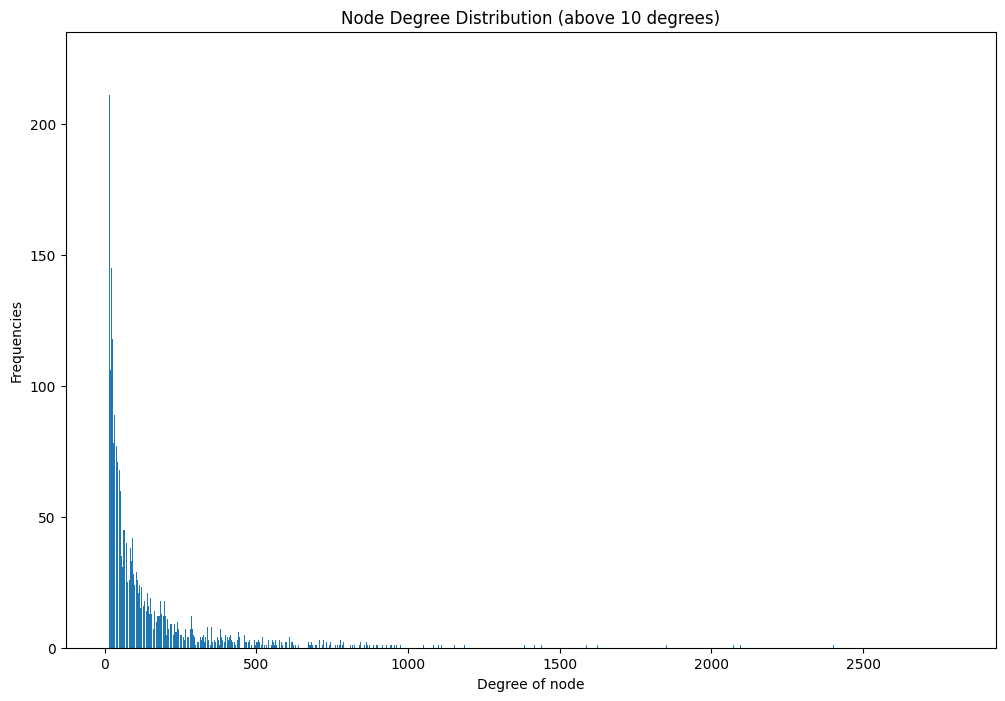

In [38]:
# DEGREE DISTRIBUTION - bar chart
y_frequencies = []
x_degrees = []
for degree, frequency in degree_freq.items():
    y_frequencies.append(frequency)
    x_degrees.append(degree)
# Sorting the degrees to ensure proper ordering
x_degrees, y_frequencies = zip(*sorted(zip(x_degrees, y_frequencies)))

# Limiting to the first 100 items
x_degrees = x_degrees[10:]
y_frequencies = y_frequencies[10:]
plt.figure(figsize=(12,8))
plt.bar(x_degrees, y_frequencies)
plt.xticks()
plt.xlabel('Degree of node')
plt.ylabel('Frequencies')
plt.title('Node Degree Distribution (above 10 degrees)')
plt.show()

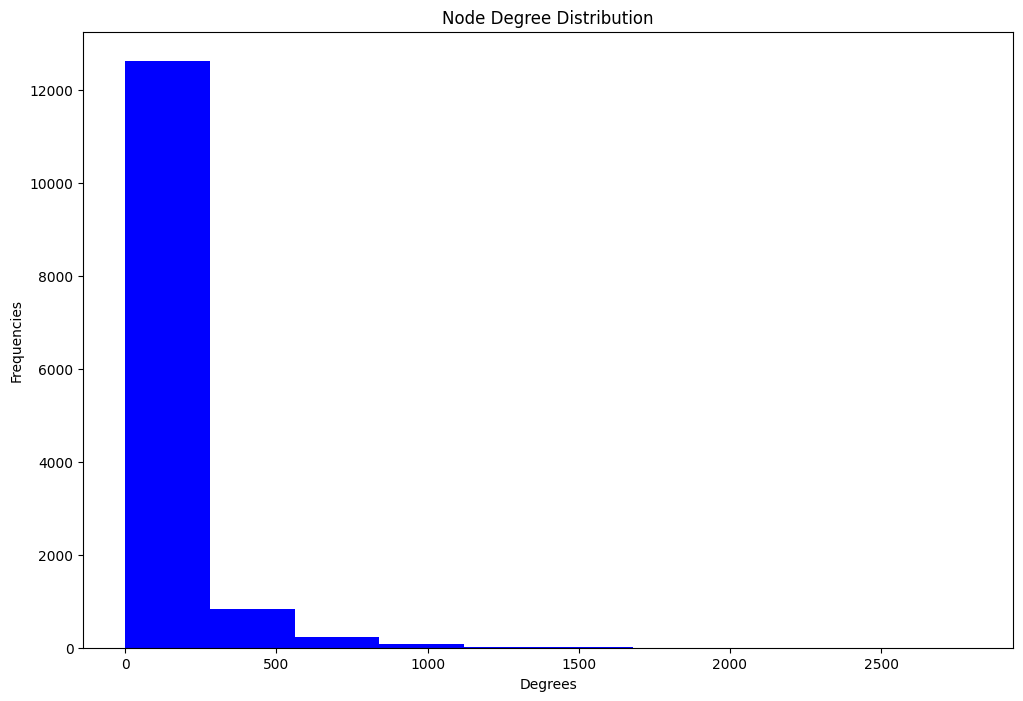

In [39]:
# DEGREE DISTRIBUTION - histogram
plt.figure(figsize=(12,8))

plt.hist(degrees, bins = 10, color = 'blue')
plt.xlabel('Degrees')
plt.ylabel('Frequencies')
plt.title('Node Degree Distribution')
plt.show()

In [ ]:
# Nodes color spectrum based on publication count

# Map values to colors based on color map
def get_colors(nodes, cmap):
    if not nodes:
        return {}
    values = list(nodes.values())
    norm = mcolors.Normalize(vmin=min(numpy.log1p(values)), vmax=max(numpy.log1p(values)))   # normalizing all values on a scale of 0 to 1 for coloring
    cmap = cm.get_cmap(cmap)
    return {node: cmap(norm(value)) for node, value in nodes.items()}

# Apply colormap to each category's nodes and collect colors
def nodes_apply_colormap(G):
    # Creating a dict and storing all genes
    disease_assoc = {}
    non_disease_assoc = {}
    non_omim = {}
    merged = {}
    for node in G.nodes:
        if node not in node_df.index:
            merged[node] = 1
            continue
        disease_cat = node_df.loc[node]['disease_assoc_cat']
        if disease_cat == 'disease_assoc':
            disease_assoc[node] = node_df.loc[node]['publication_count']
        elif disease_cat == 'non_disease_assoc':
            non_disease_assoc[node] = node_df.loc[node]['publication_count']
        elif disease_cat == 'non_omim':
            non_omim[node] = node_df.loc[node]['publication_count']
        else:
            merged[node] = 1
    # Identifying base colors for each category
    base_colors = {'disease_assoc':'Reds', 'non_disease_assoc':'Blues', 'non_omim': 'Grays', 1:'Grays'}

    # Mapping the categories to each other to normalize
    all_nodes = {'disease_assoc': disease_assoc,'non_disease_assoc': non_disease_assoc, 'non_omim': non_omim, 1:merged}

    # Storing node colors in a list
    node_colors = []
    for category, nodes in all_nodes.items():
        if category not in base_colors:
            print(f"Category {category} is not in base colors")
        else:
            cmap_name = base_colors[category]
            colors = get_colors(nodes, cmap_name)
            if category == 'unknown':
                colors = {node: (0, 0, 0, 1) for node in nodes} # Making 'unknown' nodes black
            node_colors.extend(colors[node] for node in G.nodes if node in colors)
    return node_colors

node_colors = nodes_apply_colormap(geneGraph)
print(node_colors)

In [6]:
# Creating a dictionary that assigns nodes to their disease association in a dict
nodes_list = list(geneGraph.nodes)
disease_cat_dict = {}
for node in nodes_list:
    disease_assoc_cat = node_df.loc[node]['disease_assoc_cat']
    if disease_assoc_cat == 'disease_assoc':
        disease_cat_dict[node] = {'category':'disease_assoc'}
    elif disease_assoc_cat == 'non_disease_assoc':
        disease_cat_dict[node] = {'category':'non_disease_assoc'}
    elif disease_assoc_cat == 'non_omim':
        disease_cat_dict[node] = {'category':'non_omim'}
    else:
        print ('failed')

# Assigning the attrubutes to the nodes
nx.set_node_attributes(geneGraph, disease_cat_dict)

# Creating a color map for the categories to colors
node_color_map = {'disease_assoc':'tab:red','non_disease_assoc':'tab:blue','non_omim':'gray'}
node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]

print(node_colors)

['tab:red', 'tab:red', 'tab:blue', 'tab:red', 'tab:blue', 'tab:blue', 'tab:red', 'tab:blue', 'tab:blue', 'tab:red', 'tab:red', 'tab:red', 'tab:red', 'gray', 'tab:red', 'tab:red', 'tab:red', 'gray', 'tab:blue', 'tab:red', 'tab:blue', 'tab:blue', 'tab:red', 'tab:red', 'tab:blue', 'tab:red', 'tab:blue', 'tab:red', 'tab:red', 'tab:blue', 'tab:red', 'tab:red', 'tab:blue', 'tab:red', 'tab:blue', 'tab:red', 'tab:red', 'tab:red', 'tab:blue', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:red', 'tab:blue', 'tab:blue', 'tab:red', 'tab:red', 'tab:blue', 'tab:red', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:red', 'tab:red', 'tab:red', 'tab:blue', 'tab:red', 'tab:blue', 'tab:blue', 'tab:red', 'tab:blue', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:red', 'gray', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:red', 'tab:blue', 'tab:blue', 'tab:b

In [ ]:
# Coloring edges by 6 sections of interaction_type

# GPT's 6 sections of the 84 items
genetic_interactions = ['cisphenotypic genetic ','mutual genetic over-su','association', 'genetic interaction', 'genetic suppression', 'genetic suppression (p', 'genetic suppression (c', 'genetic enhancement', 'genetic epistasis (sen', 'phenotypic suppression', 'asynthetic genetic int', 'cisphenotypic co-suppr', 'opposing genetic epist', 'minimal genetic epista', 'synthetic growth defec', 'transphenotypic enhanc', 'transphenotypic geneti', 'genetic over-suppressi', 'negative genetic inter', 'positive genetic inter']
physical_interactions = ['self interaction','physical association', 'direct interaction', 'colocalization', 'proximity', 'protein cleavage', 'disulfide bond', 'Co-localization', 'Co-fractionation', 'Co-purification', 'Co-crystal Structure', 'Protein-peptide', 'Protein-RNA']
post_translational_modifications = ['phosphorylation','demethylation reaction', 'phosphorylation reacti', 'acetylation reaction', 'covalent binding', 'cleavage reaction', 'dephosphorylation reac', 'ubiquitination reactio', 'methylation reaction', 'deacetylation', 'cleavage', 'dephosphorylation', 'methylation', 'ubiquitination', 'deformylation reaction']
experimental_methods = ['Affinity Capture-RNA', 'Affinity Capture-Weste', 'Affinity Capture-MS', 'Two-hybrid', 'Biochemical Activity', 'Reconstituted Complex', 'Negative Genetic', 'Positive Genetic', 'PCA', 'FRET', 'Proximity Label-MS', 'Far Western', 'Affinity Capture-Lumin']
synthetic_rescue_and_dosage_interactions = ['dosage lethality (sens','synthetic genetic inte', 'mutual genetic enhance', 'maximal genetic epista', 'synthetic rescue (sens', 'dosage rescue (sensu B', 'synthetic rescue (sens', 'synthetic lethality (s', 'synthetic haploinsuffi', 'dosage rescue (sensu b', 'dosage growth defect (', 'Synthetic Rescue', 'Synthetic Lethality', 'Dosage Lethality', 'Dosage Rescue',  'Dosage Growth Defect', 'Synthetic Growth Defec', 'Synthetic Haploinsuffi']
phenotypic_interactions = ['monophenotypic genetic', 'phenotypic enhancement', 'putative self interact', 'cisphenotypic inter-su', 'cisphenotypic inter-suppr', 'Phenotypic Suppression', 'Phenotypic Enhancement']

def color_edge_section(G):
    # Creating a dict that assigns each interaction_type to its respective section
    interaction_section_dict = {}
    for index, row in edge_df.iterrows():
        edge = (row['source'], row['target'])
        interaction_type = row['interaction_type']
        if interaction_type in genetic_interactions:
            interaction_section_dict[edge] = {'category':'Genetic Interaction'}
        elif interaction_type in physical_interactions:
            interaction_section_dict[edge] = {'category':'Physical Interaction'}
        elif interaction_type in post_translational_modifications:
            interaction_section_dict[edge] = {'category':'Post Translational Modification'}
        elif interaction_type in experimental_methods:
            interaction_section_dict[edge] = {'category':'Experimental Method'}
        elif interaction_type in synthetic_rescue_and_dosage_interactions:
            interaction_section_dict[edge] = {'category':'Synthetic Rescue and Dosage Interaction'}
        elif interaction_type in phenotypic_interactions:
            interaction_section_dict[edge] = {'category':'Phenotypic Interaction'}
        else:
            print(f'edge color failed for {interaction_type}')
            interaction_section_dict[edge] = {'category':'Unknown'}


    # Assigning attributes to edge
    nx.set_edge_attributes(G, interaction_section_dict)

    # Creating a color map that maps each section to a color
    edge_section_color_map = {'Genetic Interaction':'orange', 'Physical Interaction':'yellow', 'Post Translational Modification':'green','Experimental Method':'purple','Synthetic Rescue and Dosage Interaction':'pink','Phenotypic Interaction':'brown', 'Unknown':'black'}

    edge_colors_int_section = [edge_section_color_map.get(G.edges[edge].get('category', 'Unknown'), 'black') for edge in G.edges]    
    # edge_colors_int_section = [edge_section_color_map[G.edges[edge]['category']] for edge in G.edges]
    return edge_colors_int_section


In [ ]:
# # Coloring  edges by 5 top interaction types

# interaction_type_dict = {}
# for index, edge in enumerate(geneGraph.edges):
#     interaction_type = edge_df.loc[index]['interaction_type']
#     if interaction_type == 'Negative Genetic':
#         interaction_type_dict[edge] = {'category':'Negative Genetic'}
#     elif interaction_type == 'physical association':
#         interaction_type_dict[edge] = {'category':'physical association'}
#     elif interaction_type == 'Affinity Capture-MS':
#         interaction_type_dict[edge] = {'category':'Affinity Capture-MS'}
#     elif interaction_type == 'direct interaction':
#         interaction_type_dict[edge] = {'category':'direct interaction'}
#     elif interaction_type == 'Positive Genetic':
#         interaction_type_dict[edge] = {'category':'Positive Genetic'}
#     else:
#         interaction_type_dict[edge] = {'category':'other'}

# # Assigning attributes to edge
# nx.set_edge_attributes(geneGraph, interaction_type_dict)

# # Creating a color map to map the interaction types to colors
# edge_type_color_map = {'Negative Genetic':'orange','physical association':'yellow','Affinity Capture-MS':'green','direct interaction':'purple', 'Positive Genetic':'pink', 'other':'black'}
# edge_colors_int_type = [edge_type_color_map[geneGraph.edges[edge]['category']]for edge in geneGraph.edges]

In [ ]:
# # Coloring edges by interaction_cat

# # Creating a dictionary that assigns edges to their interaction_cat in a dict
# interaction_cat_dict = {}
# for index,edge in enumerate(geneGraph.edges):
#     interaction_cat = edge_df.loc[index]['interaction_cat']
#     if interaction_cat == 'physical':
#         interaction_cat_dict[edge] = {'category':'physical'}
#     elif interaction_cat == 'genetic':
#         interaction_cat_dict[edge] = {'category':'genetic'}
#     else:
#         print('failed')

# # Assigning attributes to edge
# nx.set_edge_attributes(geneGraph, interaction_cat_dict)

# # Creating a color map for the categories to colors
# edge_cat_color_map = {'physical':'orange', 'genetic':'green'}
# edge_colors_int_cat = [edge_cat_color_map[geneGraph.edges[edge]['category']] for edge in geneGraph.edges]


In [ ]:
# # Thickness of the edges correspond to interaction_count

# def edge_thickness(G):
#     # Creating a dictionary that assigns edges to their interaction_count in a dict
#     interaction_count_dict = {}
#     for index, edge in enumerate(G.edges):
#         interaction_count = edge_df.iloc[index]['interaction_count']
#         if interaction_count == 1:
#             interaction_count_dict[edge] = {'count':1}
#         elif interaction_count == 2:
#             interaction_count_dict[edge] = {'count':2}
#         elif interaction_count == 3:
#             interaction_count_dict[edge] = {'count':3}
#         elif interaction_count == 4:
#             interaction_count_dict[edge] = {'count':4}
#         elif interaction_count == 5:
#             interaction_count_dict[edge] = {'count':5}
#         elif interaction_count == 6:
#             interaction_count_dict[edge] = {'count':6}
#         else:
#             print('failed')

#     # Assigning attributes to edge
#     nx.set_edge_attributes(G, interaction_count_dict)

#     # Creating a width map for the categories to colors
#     # edge_width_map = {1:0.02,2:0.07,3:.12,4:.17,5:.22,6:.27}    #thinner
#     edge_width_map = {1:0.2,2:0.7,3:1.2,4:1.7,5:2.2,6:2.7}    #thicker
#     edge_widths = [edge_width_map[G.edges[edge]['count']] for edge in G.edges]
#     return edge_widths


In [ ]:
# Changing style of edges by interaction_cat

def edge_style(G):
    # Creating a dictionary that assigns edges to their interaction_cat in a dict
    int_cat_dict = {}
    for index,edge in enumerate(G.edges):
        interaction_cat = edge_df.loc[index]['interaction_cat']
        if interaction_cat == 'physical':
            int_cat_dict[edge] = {'category':'physical'}
        elif interaction_cat == 'genetic':
            int_cat_dict[edge] = {'category':'genetic'}
        else:
            print('category not found')
            int_cat_dict[edge] = {'category':'unknown'}

    # Assigning attributes to edge
    nx.set_edge_attributes(G, int_cat_dict)

    # Creating a style map for the categories to colors
    edge_cat_style_map = {'physical':'dotted', 'genetic':'solid', 'unknown':'dashed'}
    edge_styles_int_cat = [edge_cat_style_map[G.edges[edge]['category']] for edge in G.edges]
    return edge_styles_int_cat


In [ ]:
edge_colors_int_section = color_edge_section(geneGraph)
edge_styles_int_cat = edge_style(geneGraph)
node_colors = nodes_apply_colormap(geneGraph)

print(len(edge_colors_int_section))
print(len(edge_styles_int_cat))
print(len(geneGraph.edges))
print(len(edge_list))

print(len(geneGraph.nodes))
print(len(node_colors))

In [ ]:
# Spring layout - colored by interaction_cat
edge_colors_int_section = color_edge_section(geneGraph)
edge_styles_int_cat = edge_style(geneGraph)
node_colors = nodes_apply_colormap(geneGraph)
pos = nx.spring_layout(geneGraph, k=0.7, iterations=15, seed = 400) #scale
fig, ax = plt.subplots(figsize=(12, 8))
nx.draw(geneGraph, pos, with_labels=False, width = 0.1, node_color=node_colors, edge_color = edge_colors_int_section, style = edge_styles_int_cat, node_size=5) #, font_size = 10, font_color='black')

# # Showing the color bars
# for category, nodes in all_nodes.items():
#     cmap_name = base_colors[category]
#     values = list(nodes.values())
#     norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
#     cmap = cm.get_cmap(cmap_name)
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])
#     plt.colorbar(sm, ax=ax, label=category)

# plt.show()

In [ ]:
# #Spring layout - colored by 5 top interaction types
# node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
# geneGraph.add_edges_from(edge_list)
# pos = nx.spring_layout(geneGraph, k=0.7, iterations=15, seed = 400) #scale
# nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_type, node_color=node_colors, node_size=5) #, font_size = 10, font_color='black')
# plt.figure(figsize=(100, 50))
# plt.show()

In [ ]:
# # Spring layout - colored by 6 interaction type sections
# node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
# geneGraph.add_edges_from(edge_list)
# pos = nx.spring_layout(geneGraph, k=0.7, iterations=15, seed = 400) #scale
# nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_section, node_color=node_colors, node_size=5) #, font_size = 10, font_color='black')
# plt.figure(figsize=(100, 50))
# plt.show()

In [ ]:
# # Spiral (equidistant)
# pos = nx.spiral_layout(geneGraph, scale=1, center=None, dim=2, resolution=0.35, equidistant=True)
# nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_cat, node_color=node_colors, node_size=5) #, font_size = 10, font_color='black')
# plt.figure(figsize=(100, 50))
# plt.show()

In [ ]:
# # Spiral (sparkler)
# node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
# geneGraph.add_edges_from(edge_list)
# pos = nx.spiral_layout(geneGraph, scale=1, center=None, dim=2, resolution=0.35, equidistant=False)
# nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_cat, node_color=node_colors, node_size=20) #, font_size = 10, font_color='black')
# plt.figure(figsize=(100, 50))
# plt.show()

In [ ]:
# # Circular
# node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
# geneGraph.add_edges_from(edge_list)
# pos = nx.circular_layout(geneGraph, scale=1, center=None, dim=2)
# nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_cat, node_color=node_colors, node_size=20) #, font_size = 10, font_color='black')
# plt.figure(figsize=(100, 50))
# plt.show()

In [ ]:
# # Kamada Kawai
# node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
# geneGraph.add_edges_from(edge_list)
# pos = nx.kamada_kawai_layout(geneGraph, dist=None, scale=1, center=None, dim=2)
# nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_cat, node_color=node_colors, node_size=5) #, font_size = 10, font_color='black')
# plt.figure(figsize=(100, 50))
# plt.show()

In [ ]:
# # Multipartite (color grouping)
# node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
# geneGraph.add_edges_from(edge_list)
# pos = nx.multipartite_layout(geneGraph, subset_key='category', align='vertical', scale=1, center=None)
# nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_cat, node_color=node_colors, node_size=15) #, font_size = 10, font_color='black')
# plt.figure(figsize=(100, 50))
# plt.show()

In [ ]:
# # Spectral clustering
# node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
# geneGraph.add_edges_from(edge_list)
# pos = nx.spectral_layout(geneGraph, scale=1, center=None, dim=2)
# nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_cat, node_color=node_colors, node_size=70) #, font_size = 10, font_color='black')
# plt.figure(figsize=(100, 50))
# plt.show()

In [ ]:
# SPARSIFICATION - dedensify
geneGraphSparse, sparse_nodes = nx.dedensify(geneGraph, threshold=2)
print('Original graph nodes:',len(geneGraph.nodes))
print('Sparse graph nodes:',len(geneGraphSparse.nodes))
print('\nOriginal graph edges:', len(geneGraph.edges))
print('Sparse graph edges:',len(geneGraphSparse.edges))

In [ ]:
# Original graph

pos = nx.spring_layout(geneGraph, k=0.7, iterations=15, seed = 400) #scale
fig, ax = plt.subplots(figsize=(12, 8))
nx.draw(geneGraph, pos, with_labels=False, width = 0.1, node_color=node_colors, edge_color = edge_colors_int_section, style = edge_styles_int_cat, node_size=8) #, font_size = 10, font_color='black')

# Showing the color bars
for category, nodes in all_nodes.items():
    cmap_name = base_colors[category]
    values = list(nodes.values())
    norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
    cmap = cm.get_cmap(cmap_name)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label=category)

plt.show()

In [ ]:
sparse_edge_colors = color_edge_section(geneGraphSparse)
sparse_edge_styles = edge_style(geneGraphSparse)
sparse_node_colors = nodes_apply_colormap(geneGraphSparse)

print(len(sparse_node_colors))
print(len(sparse_edge_colors))
print(len(sparse_edge_styles))

print(len(geneGraphSparse.edges))
print(len(geneGraphSparse.nodes))

In [ ]:
# # Finding nodes that are the same in geneGraphSparse and new nodes that were created from merging
# consistent_nodes = []
# merged_nodes = []
# for node in geneGraphSparse.nodes():
#     if node in geneGraph.nodes():
#         consistent_nodes.append(node)
#     elif node not in geneGraph.nodes():
#         merged_nodes.append(node)

# print(len(consistent_nodes))
# print(len(merged_nodes))

# consistent_edges = []
# merged_edges = []
# for edge in geneGraphSparse.edges():
#     if edge in geneGraph.edges():
#         consistent_edges.append(edge)
#     elif edge not in geneGraph.edges():
#         merged_edges.append(edge)

# print(len(consistent_edges))
# print(len(merged_edges))

In [ ]:
# Sparsified graph
sparse_edge_colors = color_edge_section(geneGraphSparse)
sparse_edge_styles = edge_style(geneGraphSparse)
sparse_node_colors = nodes_apply_colormap(geneGraphSparse)

pos = nx.spring_layout(geneGraphSparse, k=0.7, iterations=15, seed = 400) #scale
fig, ax = plt.subplots(figsize=(12, 8))
nx.draw(geneGraphSparse, pos, with_labels=False, width = 0.1, node_color=sparse_node_colors, edge_color = sparse_edge_colors, style = sparse_edge_styles, node_size=8) #, font_size = 10, font_color='black')

# Showing the color bars
for category, nodes in all_nodes.items():
    cmap_name = base_colors[category]
    values = list(nodes.values())
    norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
    cmap = cm.get_cmap(cmap_name)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label=category)

plt.show()

In [ ]:
# Sparsification - pruning nodes based on degree distribution

# Finding all the nodes with a degree higher than 10 -- these are the only nodes that will be added to the graph
new_nodes = []
for node, degree in node_degree_dict.items():
    if degree <= 100:
        new_nodes.append(node)
    else:
        pass
# Finding respective edges based on these nodes
new_edge_list = []
for node in new_nodes:
    for edge in edge_list:
        a,b = edge
        if node == a or node == b:
            new_edge_list.append(edge)

# Initializing sparse graph and adding edges
geneGraphSparse2 = nx.Graph()
geneGraphSparse2.add_edges_from(new_edge_list)

In [ ]:
# Checking length of attributes
sparse_edge_colors2 = color_edge_section(geneGraphSparse2)
sparse_edge_styles2 = edge_style(geneGraphSparse2)
sparse_node_colors2 = nodes_apply_colormap(geneGraphSparse2)

print(len(sparse_node_colors2))
print(len(sparse_edge_colors2))
print(len(sparse_edge_styles2))

print(len(geneGraphSparse2.edges))
print(len(geneGraphSparse2.nodes))

In [ ]:
# Showing sparsified graph
pos = nx.spring_layout(geneGraphSparse2, k=0.7, iterations=15, seed = 400) #scale
fig, ax = plt.subplots(figsize=(12, 8))
nx.draw(geneGraphSparse2, pos, with_labels=False, width = 0.1, node_color=sparse_node_colors2, edge_color = sparse_edge_colors2, style = sparse_edge_styles2, node_size=8) #, font_size = 10, font_color='black')

# # Showing the color bars
# for category, nodes in all_nodes.items():
#     cmap_name = base_colors[category]
#     values = list(nodes.values())
#     norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
#     cmap = cm.get_cmap(cmap_name)
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])
#     plt.colorbar(sm, ax=ax, label=category)

plt.show()

In [ ]:
# Sparsification based on DIOPT scores

# Removing all DIOPT scores above 3
new_edges = []
for index, edge in enumerate(first_edges):
    diopt = edge_df.loc[index]['interaction_count']
    if diopt >= 3:
        new_edges.append(edge)

new_edges_list= list(map(edge_tuples, new_edges))

geneGraphSparse3 = nx.Graph()
geneGraphSparse3.add_edges_from(new_edges_list)


In [ ]:
# Checking length of attributes
sparse_edge_colors3 = color_edge_section(geneGraphSparse3)
sparse_edge_styles3 = edge_style(geneGraphSparse3)
sparse_node_colors3 = nodes_apply_colormap(geneGraphSparse3)

print(len(sparse_node_colors3))
print(len(sparse_edge_colors3))
print(len(sparse_edge_styles3))

print(len(geneGraphSparse3.edges))
print(len(geneGraphSparse3.nodes))

In [ ]:
# Showing sparsified graph
pos = nx.spring_layout(geneGraphSparse3, k=0.7, iterations=15, seed = 400) #scale
fig, ax = plt.subplots(figsize=(12, 8))
nx.draw(geneGraphSparse3, pos, with_labels=False, width = 0.1, node_color=sparse_node_colors3, edge_color = sparse_edge_colors3, style = sparse_edge_styles3, node_size=8) #, font_size = 10, font_color='black')

# # Showing the color bars
# for category, nodes in all_nodes.items():
#     cmap_name = base_colors[category]
#     values = list(nodes.values())
#     norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
#     cmap = cm.get_cmap(cmap_name)
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])
#     plt.colorbar(sm, ax=ax, label=category)

plt.show()

In [ ]:
# Random walk (first order)
def random_walk(G, start_node, num_steps):
    walk = [start_node]
    current_node = start_node

    for _ in range(num_steps):
        neighbors = list(G.neighbors(current_node))
        if neighbors == 0:
            break
        next_node = random.choice(neighbors)
        walk.append(next_node)
        current_node = next_node

    return walk

# Random walk (second order)
def second_order_random_walk(graph, start_node, num_steps, p, q):
    walk = [start_node]
    current_node = start_node
    previous_node = None

    for _ in range(num_steps):
        neighbors = list(graph.neighbors(current_node))
        if not neighbors:
            break

        if previous_node is None:
            # First step, no previous node
            next_node = random.choice(neighbors)
        else:
            probabilities = []
            for neighbor in neighbors:
                if neighbor == previous_node:
                    probabilities.append(1 / p)
                elif graph.has_edge(previous_node, neighbor):
                    probabilities.append(1)
                else:
                    probabilities.append(1 / q)

            # Normalize probabilities
            probabilities = np.array(probabilities)
            probabilities /= probabilities.sum()

            # Choose next node based on the transition probabilities
            next_node = np.random.choice(neighbors, p=probabilities)

        walk.append(next_node)
        previous_node = current_node
        current_node = next_node

    return walk

random_walk(geneGraph, 9722, 50)

In [ ]:
# Using Node2Vec and UMAP to make nonlinear plots

# Initialize node2vec model
node2vec = Node2Vec(geneGraph, dimensions=64, walk_length=30, num_walks=200, workers=4)

# # Build the vocabulary
# model = node2vec.fit(window=10, min_count=1, batch_words=4)

# # Save embeddings for later use
# model.wv.save_word2vec_format('gene_node_embeddings.emb')

In [ ]:
# ADJACENCY MATRIX

verticies = len(list(geneGraph.nodes()))
node_name_list = list(geneGraph.nodes())

# (Converting the elements from node_name_list from int to str)
node_list = []
for node in node_name_list:
    node = str(node)
    node_list.append(node)

# Mapping each node to an index and index to a node
node_to_index = {node: index for index,node in enumerate(nodes_list)}
index_to_node = {index: node for index,node in enumerate(nodes_list)}


# Converting each node from its name to its index
edge_index_list = []
for node1, node2 in edge_list:
    node1_index = node_to_index[node1]
    node2_index = node_to_index[node2]
    edge_index_list.append((node1_index, node2_index))

# Making an empty matrix
adj_matrix = [[0] * verticies for __ in range(verticies)]

# Add values to the matrix
for node1, node2 in edge_index_list:
    adj_matrix[node1][node2] = 1       # Becuase this is a directed graph

# Printing labels for the matrix
print("\nMatrix with Labels:")
print(" " + " ".join(node_list))
print("  " + "-" * (4 * verticies - 1))

# Iterate through each row of the matrix
for i, row in enumerate(adj_matrix):
    # Print the label for the current row node
    print(f"{node_name_list[i]} | " + "   ".join(map(str, row)))

